<a href="https://colab.research.google.com/github/mtomcanyi/Hackhealth2021-Challenge7/blob/main/ZCase_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

arrivalsDF = pd.read_csv('/content/drive/MyDrive/Hackhealth2021/FordMondeo/Hackhealth2021/Challenge7-zCase/ArrivalData/arrivals-clean.csv',
                         index_col=0,
                         parse_dates=["dispatchingTs","createdTs","closedTs","destinationApproval__requestTs","destinationApproval__responseTs"])
arrivalsDF.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (40,43,64,66,67,68,73) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(48863, 74)

In [ ]:
! head -n 20 /content/drive/MyDrive/Hackhealth2021/FordMondeo/Hackhealth2021/Challenge7-zCase/ArrivalData/arrivals-clean.csv


## Timestmap parsing check
Check that timestmaps were re-imported correctly from cleansed CSV and the  difference in minutes between `createdTs` and `dispatchingTs` captured in `createdTs__minutes` is correctly preserved after we parsed into Python timestampts.

In [ ]:
arrivalsDF.loc[:,["dispatchingTs","createdTs","closedTs","destinationApproval__requestTs","destinationApproval__responseTs"]]


# check interval computed from timestamps vs interval from data

#arrivalsDF["MinDiff"] = (arrivalsDF["createdTs"] - arrivalsDF["dispatchingTs"]).dt.total_seconds()/60
#arrivalsDF[["MinDiff","createdTs__minutes"]]

,dispatchingTs,createdTs,closedTs,destinationApproval__requestTs,destinationApproval__responseTs
0,2020-08-31 15:33:45+00:00,2020-08-31 16:12:01.591000+00:00,2020-08-31 16:55:52.014000+00:00,2020-08-31 16:12:01.690000+00:00,2020-08-31 16:12:08.975000+00:00
1,2020-08-31 15:51:47+00:00,2020-08-31 16:12:28.315000+00:00,2020-08-31 17:47:04.386000+00:00,2020-08-31 16:12:28.399000+00:00,2020-08-31 16:12:37.591000+00:00
2,2020-08-31 16:01:25+00:00,2020-08-31 16:15:28.424000+00:00,2020-08-31 16:41:30.002000+00:00,2020-08-31 16:15:28.516000+00:00,NaT
3,2020-08-31 16:21:05+00:00,2020-08-31 16:59:30.841000+00:00,2020-08-31 18:10:40.979000+00:00,2020-08-31 16:59:30.937000+00:00,2020-08-31 17:00:16.401000+00:00
4,2020-08-31 16:31:04+00:00,2020-08-31 17:22:40.829000+00:00,2020-08-31 18:24:00.843000+00:00,2020-08-31 17:22:40.912000+00:00,NaT
...,...,...,...,...,...
48970,2021-11-16 12:57:21+00:00,2021-11-16 13:52:01.441000+00:00,NaT,NaT,NaT
48971,2021-11-16 13:55:16+00:00,2021-11-16 13:55:22.043000+00:00,NaT,NaT,NaT
48972,2021-11-16 13:48:29+00:00,2021-11-16 13:57:20.033000+00:00,NaT,NaT,NaT
48973,2021-11-16 13:55:05+00:00,2021-11-16 14:02:07.613000+00:00,NaT,NaT,NaT


## Seaborn and matplotlib setup

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Hospitals and cities mapping

For a foreigner or a person living outside Prague it's unclear where are the hospital located. The operational data set only contains `caseAddress__city` which seem to designate a place where ambulance picked up the patient, but no information where the hospital is located.

In [106]:
shortDF = pd.DataFrame()

shortDF["created"] = arrivalsDF["createdTs"].dt.date
shortDF["closed"] = arrivalsDF["closedTs"].dt.date
shortDF["urgency"] = arrivalsDF["patient__urgency"]
shortDF["const"] = [1] * arrivalsDF.shape[0]

# short names for hospitals
shortDF["destHospital"] = arrivalsDF["destination__hospitalName"].map({
    "Nemocnice Motol" : "Motol",
    "Oblastní nemocnice Kladno" : "Kladno",
    "Nemocnice Na Homolce" : "Homolka",
    "Nemocnice Na Bulovce" : "Bulovka",
    "Všeob. fak. nemocnice v Praze" : "VFN Praha",
    "Fak. nemocnice Král. Vinohrady" : "Vinohrady",
    "Krajská nemocnice Liberec" : "Liberec",
    "Ostatní výjezdy STCPHA" : "STCPHA",
    "Nemocnice Havířov" : "Havirov",
    "Ostatní výjezdy MSK" : "MSK",
    "Fakultní nemocnice Ostrava" : "FN Ostrava",
    "Městská nemocice Ostrava" : "MN Ostrava",
    "Ostatní výjezdy OLK" : "OLK",
    "Fakultní nemocnice Olomouc" : "Olomouc"
})

# cities
shortDF["destCity"] = arrivalsDF["destination__hospitalName"].map({
    "Nemocnice Motol" : "Praha",
    "Oblastní nemocnice Kladno" : "Kladno",
    "Nemocnice Na Homolce" : "Praha",
    "Nemocnice Na Bulovce" : "Praha",
    "Všeob. fak. nemocnice v Praze" : "Praha",
    "Fak. nemocnice Král. Vinohrady" : "Praha",
    "Krajská nemocnice Liberec" : "Liberec",
    "Ostatní výjezdy STCPHA" : "Praha",
    "Nemocnice Havířov" : "Havirov",
    "Ostatní výjezdy MSK" : "MSK",
    "Fakultní nemocnice Ostrava" : "Ostrava",
    "Městská nemocice Ostrava" : "Ostrava",
    "Ostatní výjezdy OLK" : "OLK",
    "Fakultní nemocnice Olomouc" : "Olomouc"
})

shortDF

,created,closed,urgency,const,destHospital,destCity
0,2020-08-31,2020-08-31,N3,1,Motol,Praha
1,2020-08-31,2020-08-31,N3,1,NaN,NaN
2,2020-08-31,2020-08-31,N3,1,Kladno,Kladno
3,2020-08-31,2020-08-31,N2,1,Homolka,Praha
4,2020-08-31,2020-08-31,N3,1,Bulovka,Praha
...,...,...,...,...,...,...
48970,2021-11-16,NaT,N3,1,FN Ostrava,Ostrava
48971,2021-11-16,NaT,NaN,1,NaN,NaN
48972,2021-11-16,NaT,N3,1,FN Ostrava,Ostrava
48973,2021-11-16,NaT,N3,1,Havirov,Havirov


In [110]:
pivot = shortDF.pivot_table(index="created",columns="destCity",values="const",aggfunc="sum")
pivot

destCity,Havirov,Kladno,Liberec,MSK,OLK,Olomouc,Ostrava,Praha
created,,,,,,,,
2020-08-31,NaN,5.0,NaN,NaN,NaN,NaN,NaN,17.0
2020-09-01,NaN,19.0,NaN,NaN,NaN,NaN,NaN,40.0
2020-09-02,NaN,27.0,2.0,NaN,NaN,NaN,NaN,52.0
2020-09-03,NaN,20.0,NaN,NaN,NaN,NaN,NaN,35.0
2020-09-04,NaN,19.0,NaN,NaN,NaN,NaN,NaN,30.0
...,...,...,...,...,...,...,...,...
2021-11-12,27.0,33.0,2.0,4.0,NaN,40.0,90.0,42.0
2021-11-13,40.0,35.0,NaN,3.0,NaN,41.0,104.0,43.0
2021-11-14,21.0,30.0,NaN,4.0,NaN,61.0,85.0,41.0


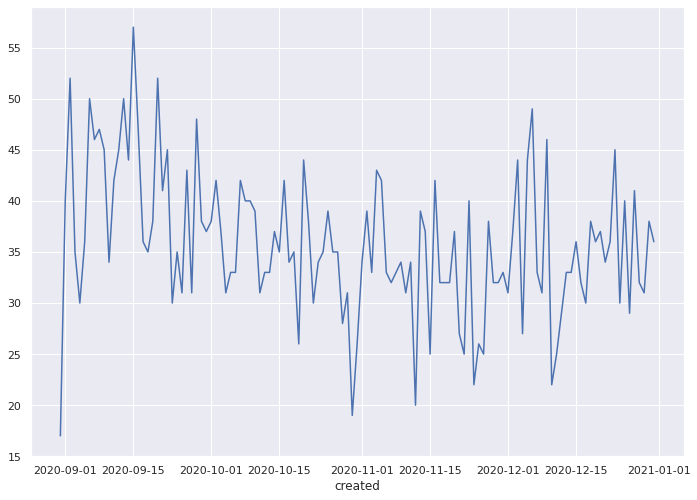

In [123]:
start = pd.to_datetime("2020-01-01").date()
end = pd.to_datetime("2020-12-31").date()

pivot.loc[start:end,"Praha"].plot()

In [89]:
arrivalsDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48739 entries, 0 to 48964
Data columns (total 75 columns):
 #   Column                                                  Non-Null Count  Dtype              
---  ------                                                  --------------  -----              
 0   version                                                 48739 non-null  int64              
 1   lastStateEventSequence                                  48739 non-null  int64              
 2   lastTimelineEventSequence                               48739 non-null  int64              
 3   dispatchingAccountId                                    48739 non-null  object             
 4   dispatchingId                                           48739 non-null  object             
 5   dispatchingTs                                           48739 non-null  datetime64[ns, UTC]
 6   createdTs                                               48739 non-null  datetime64[ns, UTC]
 7   dispatchingNa

In [81]:
arrivalsDF["destination__hospitalName"].unique()

array(['Nemocnice Motol', 'IKEM', 'Oblastní nemocnice Kladno',
       'Nemocnice Na Homolce', 'Nemocnice Na Bulovce',
       'Všeob. fak. nemocnice v Praze', 'Fak. nemocnice Král. Vinohrady',
       'Krajská nemocnice Liberec', 'Ostatní výjezdy STCPHA',
       'Nemocnice Havířov', 'Ostatní výjezdy MSK',
       'Fakultní nemocnice Ostrava', 'Městská nemocice Ostrava',
       'Ostatní výjezdy OLK', 'Fakultní nemocnice Olomouc', nan],
      dtype=object)

## Is there seasonality?
Do number of cases depend on time of the year?

In [68]:
arrivalsDF["caseDate"] = arrivalsDF["createdTs"].dt.date
d = arrivalsDF.pivot(index="caseDate",columns="destination__hospitalName",values="createdTs__minutes")




ValueError: ignored

##  How is the data set distributed regionally?


In [52]:
arrivalsDF["destination__hospitalName"].value_counts()

Oblastní nemocnice Kladno         10954
Nemocnice Havířov                  6311
Fakultní nemocnice Ostrava         5597
Nemocnice Motol                    5472
Nemocnice Na Bulovce               4589
Městská nemocice Ostrava           3918
Fakultní nemocnice Olomouc         3012
Všeob. fak. nemocnice v Praze      2739
Fak. nemocnice Král. Vinohrady     2739
IKEM                               1760
Nemocnice Na Homolce                998
Ostatní výjezdy STCPHA              382
Krajská nemocnice Liberec           202
Ostatní výjezdy MSK                 100
Ostatní výjezdy OLK                  23
Name: destination__hospitalName, dtype: int64

## Cases per hospital
Despite IKEM providing us with the data set, it seems it contains much more cases for other hospitals.

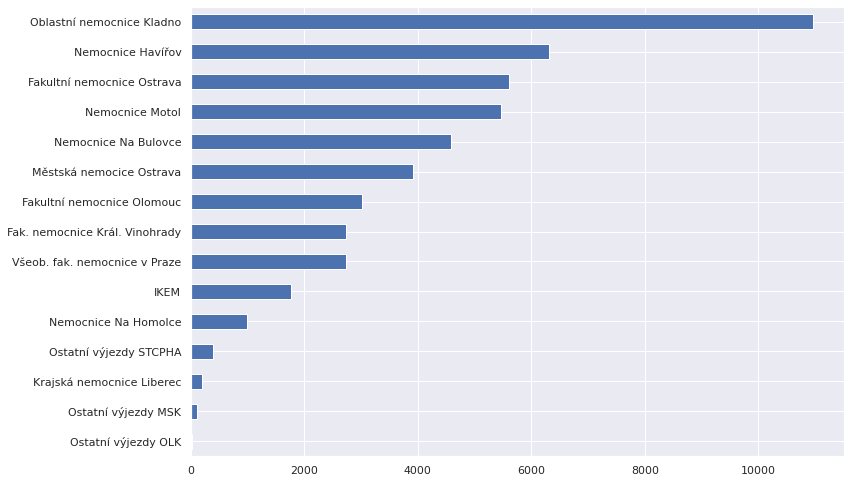

In [53]:
hospCounts = arrivalsDF["destination__hospitalName"].value_counts()
hospCounts.sort_values(inplace=True,ascending=True)
hospCounts

hospCounts.plot(kind="barh")

## Case duration compared between hospitals
Looks like some cases remain open for a very long time - thousands of `minutes` - means days and months.

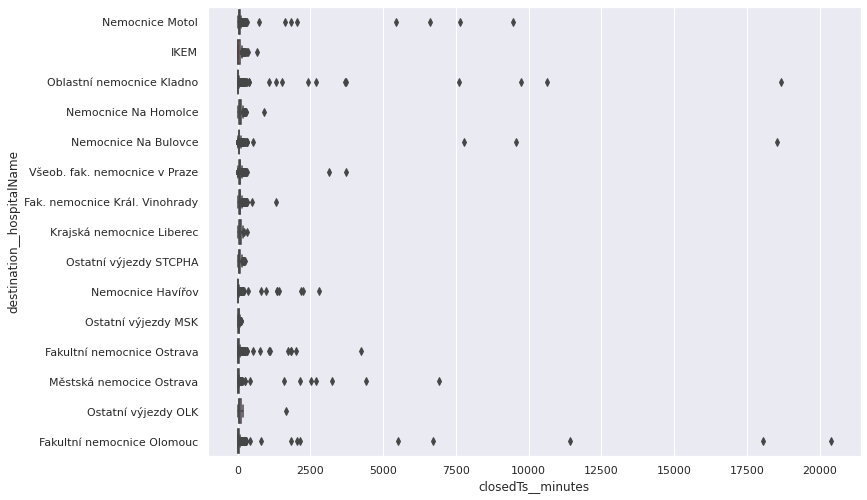

In [54]:
sns.boxplot(y=arrivalsDF["destination__hospitalName"],x=arrivalsDF["closedTs__minutes"])

## How many outliers - cases that took more than 6 hours?
Let's try to filter out suspicious outliers by filtering out cases that took `longer than 6 hours`. It's ambulance transport so logic says they should not take too many hours.

In [3]:
caseCount = arrivalsDF.loc[arrivalsDF["closedTs__minutes"]>360].shape[0]
print(f"Number of cases that took more than 6 hours: {caseCount}")

Number of cases that took more than 6 hours: 67


## Remove outliers and re-render
A bit better insigh after we removed the more-than-6-hours outliers.

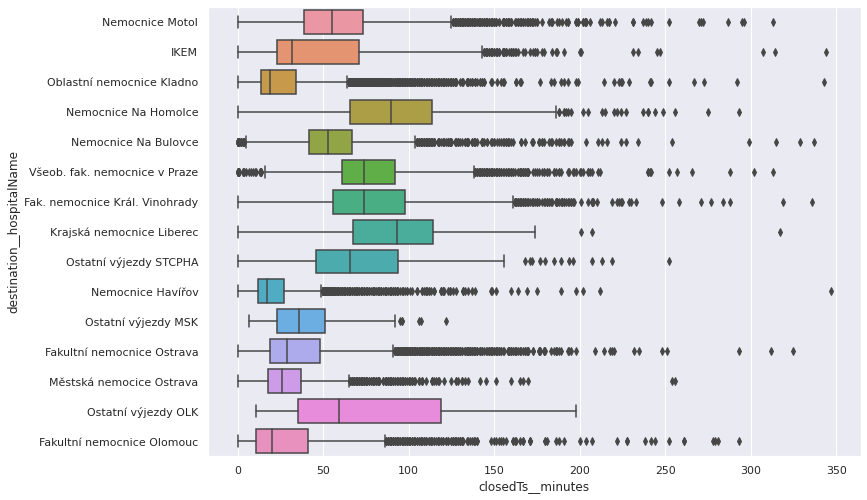

In [58]:
# Remove outliers with case duration above 6 hours - 67 cases in total
arrivalsDF = arrivalsDF.loc[arrivalsDF["closedTs__minutes"]<=360]
sns.boxplot(y=arrivalsDF["destination__hospitalName"],x=arrivalsDF["closedTs__minutes"])

## How is the data set distributed in time?


In [ ]:
arrivalsDF["createdTs__minutes"].describe()

count    48863.000000
mean        30.627612
std         18.202003
min        -54.000000
25%         21.000000
50%         29.000000
75%         39.000000
max        381.000000
Name: createdTs__minutes, dtype: float64

In [ ]:
arrivalsDF[["destination__hospitalName","closedTs__minutes"]].groupby(by="destination__hospitalName").mean()

,closedTs__minutes
destination__hospitalName,
Fak. nemocnice Král. Vinohrady,78.609712
Fakultní nemocnice Olomouc,54.583721
Fakultní nemocnice Ostrava,42.127146
IKEM,50.427516
Krajská nemocnice Liberec,91.232673
Městská nemocice Ostrava,35.758682
Nemocnice Havířov,24.320919
Nemocnice Motol,65.959240
Nemocnice Na Bulovce,64.498366


## Acute secondary transports

In [3]:
is_acute_secondary = arrivalsDF["patient__classification"].str.contains("SEKUNDÁRNÍ TRANSPORT AKUTNÍ",case=False,na=False)
is_to_ikem = arrivalsDF["destination__hospitalName"].str.contains("IKEM",case=False,na=False)

is_secondary_to_ikem = is_acute_secondary & is_to_ikem
acuteToIKEM = arrivalsDF.loc[is_secondary_to_ikem]


# Test Data Creation

---



## ShuffleSplit data set

The `ShuffleSplit` might be disrupting temporal data order. Wanting to use delayed SECONDARY TRANSPORTS from other hospitals to IKEM as one feature of prediction, we should probably aim to preseve temporal order.

In [34]:
from sklearn.model_selection import train_test_split

trainShuf, testShuf = train_test_split(arrivalsDF, test_size=0.2, random_state=20211120, shuffle=True)

print(trainShuf.shape)
print(testShuf.shape)

trainShuf.to_csv('/content/drive/MyDrive/Hackhealth2021/arrivals-train80-shuf.csv')
testShuf.to_csv('/content/drive/MyDrive/Hackhealth2021/arrivals-test20-shuf.csv')


(39090, 74)
(9773, 74)


## KFold data set

The KFold preserves data order.
But it's also deemed to be [unsuitable for time series](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4) because:

*In the case of time series, the cross-validation is not trivial. We cannon choose random samples and assign them either to the test set or the train set because it makes no sense to use values from the future to forecast values in the past. In simple words we want to avoi future-looking when we train our model. There is a temporal dependency between observation and we must preserve that relation during testing*

In [64]:
from sklearn.model_selection import KFold

splitCount = 2
# splitCount = 5

kf = KFold(n_splits=splitCount)
i=0
for kfTrainIdx,kfTestIdx in kf.split(arrivalsDF):
  trainKF = arrivalsDF.iloc[kfTrainIdx]
  testKF = arrivalsDF.iloc[kfTestIdx]
  trainKF.to_csv(f'/content/drive/MyDrive/Hackhealth2021/arrivals-train-kfold{splitCount}-{i}.csv')
  testKF.to_csv(f'/content/drive/MyDrive/Hackhealth2021/arrivals-test-kfold{splitCount}-{i}.csv')
  print(f"------------------Fold[{ i }]---------------------------------")
  print(f"Train index: Range: { kfTrainIdx.min() } - { kfTrainIdx.max() } / Size: { kfTrainIdx.size }")
  print(f"Test index: Range: { kfTestIdx.min() } - { kfTestIdx.max() } / Size: {kfTestIdx.size }")
  i += 1

------------------Fold[0]---------------------------------
Train index: Range: 24432 - 48862 / Size: 24431
Test index: Range: 0 - 24431 / Size: 24432
------------------Fold[1]---------------------------------
Train index: Range: 0 - 24431 / Size: 24432
Test index: Range: 24432 - 48862 / Size: 24431
